In [75]:
#Libraries
import numpy as np
import pandas_datareader as pdr
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
!pip install yfinance 
import yfinance as yfin
plt.style.use('fivethirtyeight')

In [76]:
#get stock data and show

yfin.pdr_override()
df = yfin.download('TCS.NS' , start='2010-01-01', end='2021-10-01')

#show

df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,377.399994,379.450012,374.524994,375.825012,299.748199,1963682
2010-01-05,377.500000,379.774994,373.274994,375.924988,299.827972,2014488
2010-01-06,375.924988,376.100006,366.500000,367.424988,293.048492,3349176
2010-01-07,367.750000,369.700012,355.500000,357.200012,284.893341,6474892
2010-01-08,358.000000,359.250000,348.250000,349.899994,279.071106,6048178
...,...,...,...,...,...,...
2021-09-24,3890.000000,3944.399902,3855.000000,3871.300049,3863.886230,2320754
2021-09-27,3900.000000,3904.000000,3802.899902,3836.949951,3829.601807,1673362
2021-09-28,3850.000000,3850.000000,3751.250000,3779.149902,3771.912354,2253075


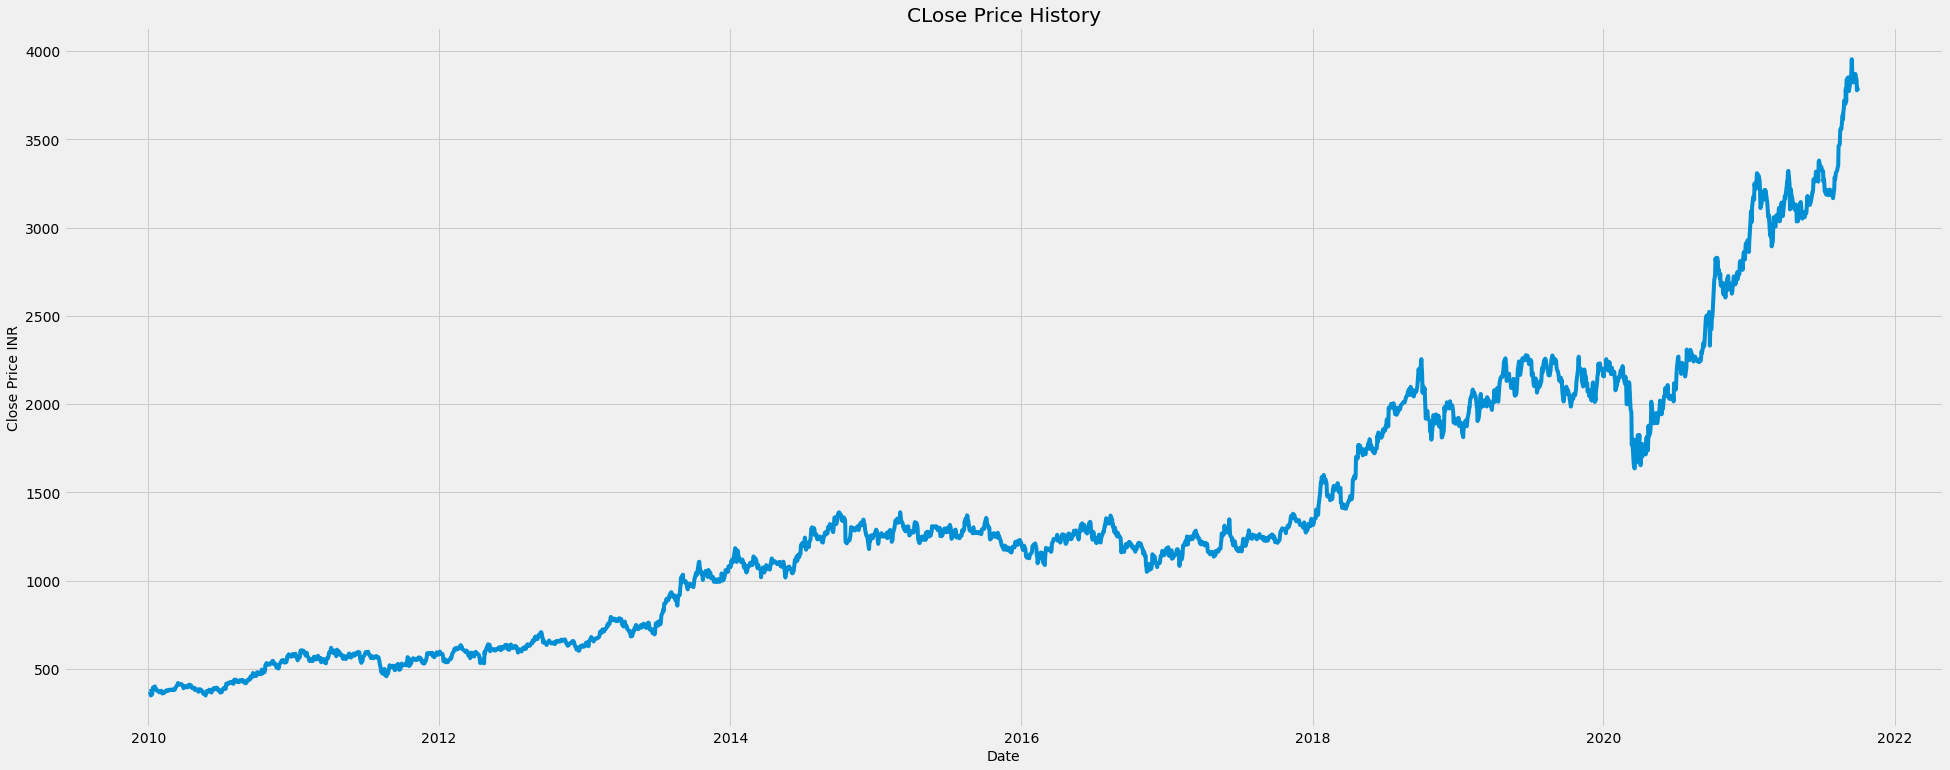

In [77]:
#graph of closing price
plt.figure(figsize=(30,12))
plt.title('CLose Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price INR', fontsize=14)
plt.show()

In [78]:
#creating dataset with only stock closing price

data = df.filter(['Close'])

#convert data frame to NP array

dataset=data.values

tlen=math.ceil(len(dataset) *0.75)

tlen

2172

In [79]:
#scale the data between 0,1 using MinMaxScaller

scaler= MinMaxScaler( feature_range=(0,1))

scaled_data= scaler.fit_transform(dataset)

scaled_data

array([[0.00722653],
       [0.00725427],
       [0.00489628],
       ...,
       [0.95134228],
       [0.95487925],
       [0.95034364]])

In [80]:
#making trainig dataset

train_data= scaled_data [0:tlen , :]

#spliting data into x_train and y_ train
x_train=[]
y_train=[]

for i in range (240,len(train_data)): #last 240 days closing  values to train and rhen 181th day closing value which should be precticted 
  x_train.append(train_data[i-240:i , 0])
  y_train.append(train_data[i,0])

x_train,y_train=np.array(x_train),np.array(y_train)

In [81]:
print(x_train.shape)
x_train=np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) #reshaping as LSTM wants 3 dimantional data
print(x_train.shape)

(1932, 240)
(1932, 240, 1)


In [82]:
# design LSTM 

model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(60, return_sequences=False))
model.add(Dense(30))
model.add(Dense(1))

In [83]:
#compile model
model.compile(optimizer='adam', loss='mean_squared_error' )

In [84]:
model.fit(x_train,y_train, batch_size=1 , epochs= 1)

1932/1932 [==============================] - 120s 61ms/step - loss: 3.6000e-04


In [85]:
#create testing data
test_data=scaled_data[tlen-240 :, :]

#spliting to X_test,Y_test
x_test=[]
y_test=dataset[tlen: ,:]

for i in range (240,len(test_data)): #last 240 days closing  values to train and rhen 181th day closing value which should be precticted 
  x_test.append(test_data[i-240:i , 0])

x_test=np.array(x_test)

In [86]:
#reshape
print(x_test.shape)
x_test=np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1)) #reshaping as LSTM wants 3 dimantional data
print(x_test.shape)

(724, 240)
(724, 240, 1)


In [87]:
#prdict
prd=model.predict(x_test)
#invers the MinMaxScaller
prd=scaler.inverse_transform(prd)


In [88]:
#root mean squere error
rmse=np.sqrt( np.mean(prd-y_test)**2)
rmse

10.954928572006647

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


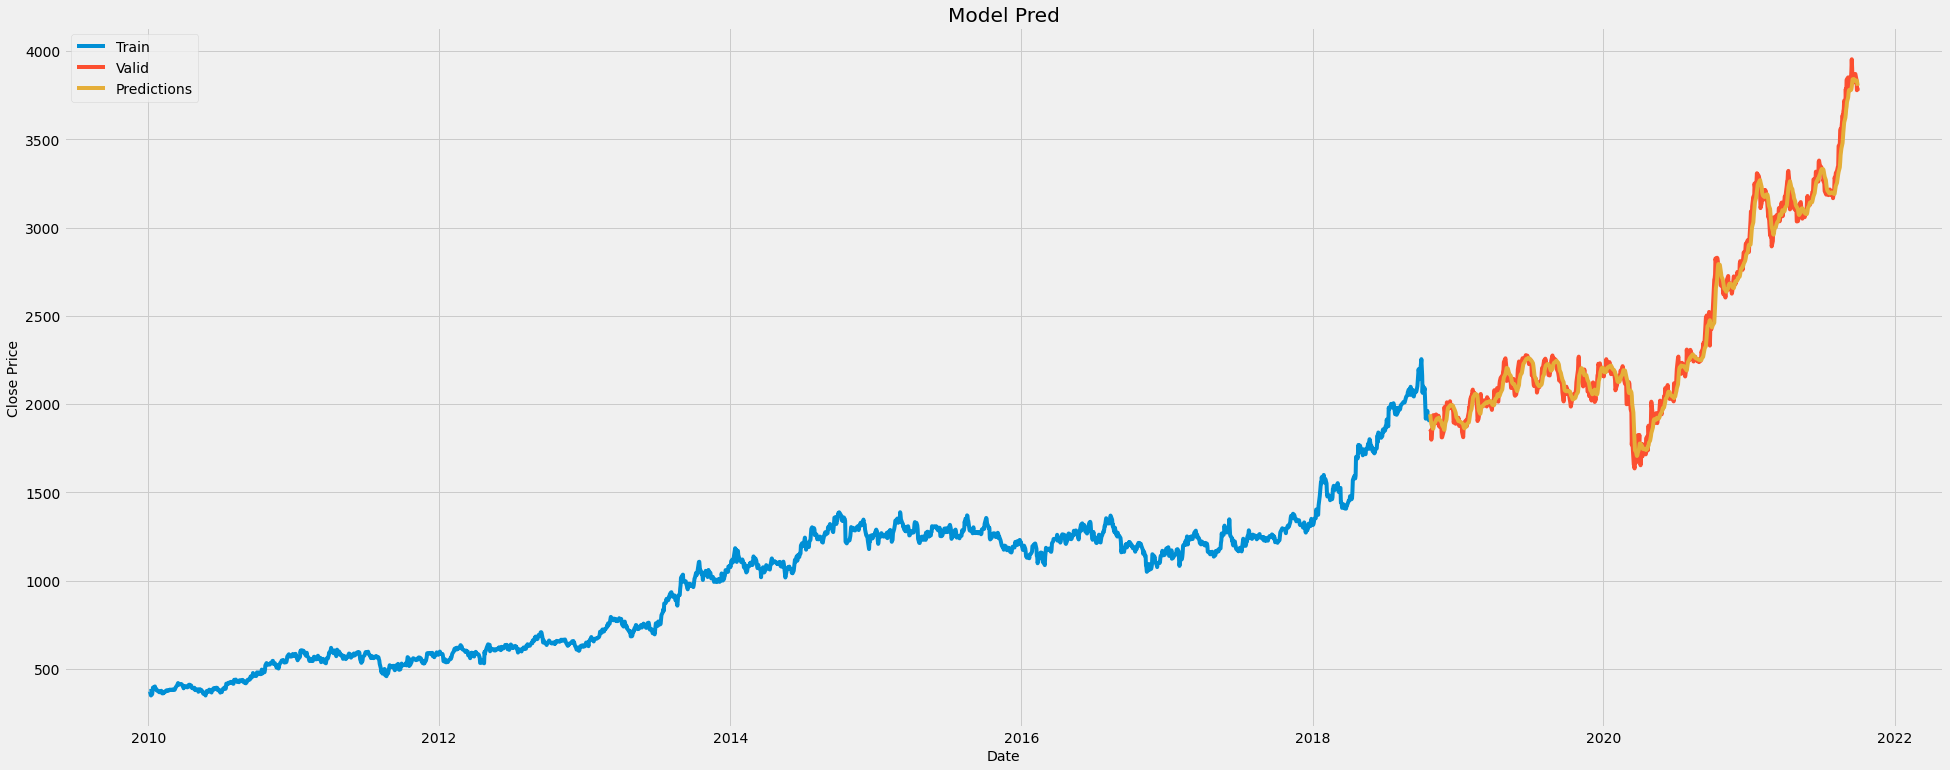

In [90]:
#plot
train=data[:tlen]
vallid=data[tlen:]
vallid['Predictions']=prd

plt.figure(figsize=(30,12))
plt.title('Model Pred')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.plot(train['Close'])
plt.plot(vallid[['Close','Predictions']])
plt.legend(['Train','Valid','Predictions'],loc='upper left')
plt.show()